In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras.models import Sequential

# Import dataset

In [29]:
import pathlib
data_dir=pathlib.Path('/content/drive/MyDrive/flower_dataset/flowers')
data_dir

PosixPath('/content/drive/MyDrive/flower_dataset/flowers')

In [30]:
classes= [i.split('/')[-1]for i in [x[0] for x in os.walk(data_dir)][1:]]
classes

['sunflower', 'tulip', 'rose', 'daisy', 'dandelion']

In [31]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp"]   # Add image formats here
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [32]:
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions(i)

# Preprocessing

In [33]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

x, y = [], []
for category, image_paths in image_dir.items():
    for path in image_paths:
        try:
            x.append(path)
            y.append(category)
        except:
            continue

# Create a DataFrame from x and y
dataFrame = pd.DataFrame({
    'filename': x,
    'category': y
})



# Shuffle the DataFrame
dataFrame['category'] = dataFrame['category'].astype('string')
dataFrame['filename'] = dataFrame['filename'].astype('string')
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)

# Display the DataFrame
dataFrame.head()

,filename,category
0,/content/drive/MyDrive/flower_dataset/flowers/...,sunflower
1,/content/drive/MyDrive/flower_dataset/flowers/...,daisy
2,/content/drive/MyDrive/flower_dataset/flowers/...,rose
3,/content/drive/MyDrive/flower_dataset/flowers/...,tulip
4,/content/drive/MyDrive/flower_dataset/flowers/...,sunflower


# Label Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
dataFrame['category']=le.fit_transform(dataFrame['category'])
dataFrame['category'] = dataFrame['category'].astype('string')

# Display the DataFrame
dataFrame.head()

,filename,category
0,/content/drive/MyDrive/flower_dataset/flowers/...,3
1,/content/drive/MyDrive/flower_dataset/flowers/...,0
2,/content/drive/MyDrive/flower_dataset/flowers/...,2
3,/content/drive/MyDrive/flower_dataset/flowers/...,4
4,/content/drive/MyDrive/flower_dataset/flowers/...,3


# Train_test_split

In [35]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(dataFrame, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [36]:
print(total_train)

800


In [37]:
print(total_validate)

200


In [38]:
type(train_df)

pandas.core.frame.DataFrame

In [39]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

In [40]:
dataFrame.category.unique()

<StringArray>
['3', '0', '2', '4', '1']
Length: 5, dtype: string

# Image generatior

In [41]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,

    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 5 classes.


In [42]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,

    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 200 validated image filenames belonging to 5 classes.


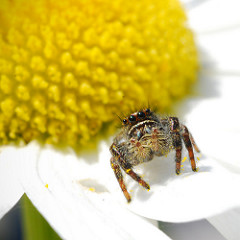

In [43]:
import PIL
PIL.Image.open(str(dataFrame['filename'][7]))

# Applying improvements techniques

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

early_stopping=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)

In [76]:
!pip install --upgrade tensorflow


In [77]:
!pip install keras


# VGG19

In [45]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential, layers

# Load the VGG19 model without the top layers
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the VGG19 layers
for layer in vgg19.layers:
    layer.trainable = False

# Build the custom model
vggModel = Sequential([
    vgg19,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
])

# Compile the model
vggModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
vggModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [46]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=5)


In [47]:
history1 = vggModel.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x78749591bc70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x78749591bc70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - ETA: 0s - loss: 6.3964 - accuracy: 0.3600

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x787495a8aef0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x787495a8aef0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


50/50 [==============================] - 41s 790ms/step - loss: 6.3964 - accuracy: 0.3600 - val_loss: 0.9706 - val_accuracy: 0.6562
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 1.3108 - accuracy: 0.5063

50/50 [==============================] - 36s 735ms/step - loss: 1.3108 - accuracy: 0.5063 - val_loss: 0.8268 - val_accuracy: 0.7188
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.5675

50/50 [==============================] - 19s 382ms/step - loss: 1.1213 - accuracy: 0.5675 - val_loss: 0.7967 - val_accuracy: 0.6927
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 1.1791 - accuracy: 0.5200

50/50 [==============================] - 32s 643ms/step - loss: 1.1791 - accuracy: 0.5200 - val_loss: 0.7823 - val_accuracy: 0.7344
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.5863

50/50 [==============================] - 17s 340ms/step - loss: 1.0723 - accuracy: 0.5863 - val_loss: 0.7536 - val_accuracy: 0.6823
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 1.1431 - accuracy: 0.5350

50/50 [==============================] - 35s 708ms/step - loss: 1.1431 - accuracy: 0.5350 - val_loss: 0.7912 - val_accuracy: 0.7552
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.5275

50/50 [==============================] - 18s 354ms/step - loss: 1.1413 - accuracy: 0.5275 - val_loss: 0.8506 - val_accuracy: 0.6146
Epoch 8/10
50/50 [==============================] - ETA: 0s - loss: 1.0703 - accuracy: 0.5738

50/50 [==============================] - 18s 353ms/step - loss: 1.0703 - accuracy: 0.5738 - val_loss: 0.6970 - val_accuracy: 0.7448
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.5088

50/50 [==============================] - 18s 363ms/step - loss: 1.1785 - accuracy: 0.5088 - val_loss: 0.8474 - val_accuracy: 0.6719
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.4700

50/50 [==============================] - 18s 366ms/step - loss: 1.1773 - accuracy: 0.4700 - val_loss: 0.7812 - val_accuracy: 0.7135


13/13 [==============================] - 1s 105ms/step - loss: 0.7843 - accuracy: 0.7150
test accuracy :  0.7149999737739563


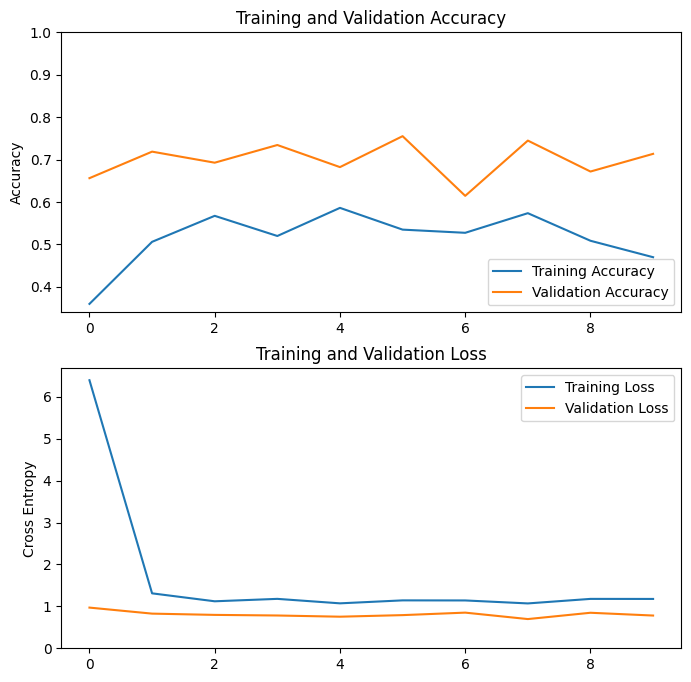

In [48]:
test_loss, test_acc = vggModel.evaluate(validation_generator)
print('test accuracy : ', test_acc)

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7874958e40d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7874958e40d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 2s 102ms/step


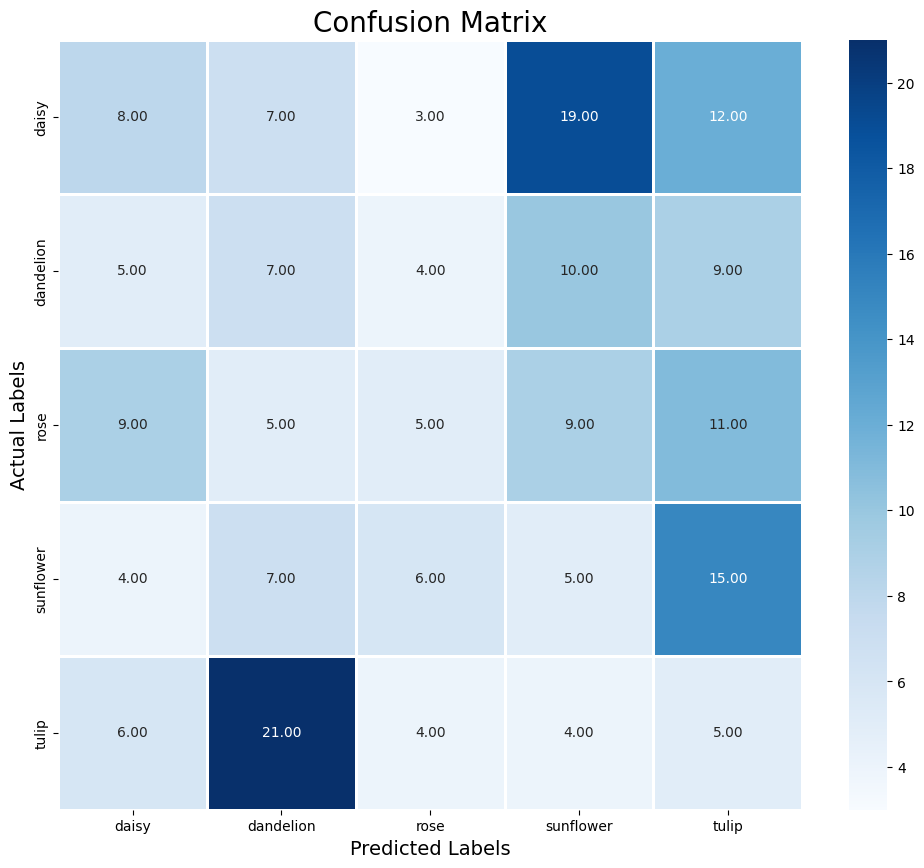

              precision    recall  f1-score   support

           0       0.25      0.16      0.20        49
           1       0.15      0.20      0.17        35
           2       0.23      0.13      0.16        39
           3       0.11      0.14      0.12        37
           4       0.10      0.12      0.11        40

    accuracy                           0.15       200
   macro avg       0.17      0.15      0.15       200
weighted avg       0.17      0.15      0.15       200



In [49]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=vggModel.predict(validation_generator)
valid_pred = [np.argmax(pred) for pred in valid_pres]
cm =confusion_matrix(validate_df['category'].astype('int'),valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(validate_df['category'].astype('int32'),valid_pred))

In [50]:
history1 = vggModel.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.5238

50/50 [==============================] - 18s 350ms/step - loss: 1.1588 - accuracy: 0.5238 - val_loss: 0.8621 - val_accuracy: 0.6562
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 1.1389 - accuracy: 0.5412

50/50 [==============================] - 19s 366ms/step - loss: 1.1389 - accuracy: 0.5412 - val_loss: 0.6961 - val_accuracy: 0.7448
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.5275

50/50 [==============================] - 17s 345ms/step - loss: 1.1269 - accuracy: 0.5275 - val_loss: 0.8763 - val_accuracy: 0.7031
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 1.1310 - accuracy: 0.5075

50/50 [==============================] - 20s 393ms/step - loss: 1.1310 - accuracy: 0.5075 - val_loss: 0.8125 - val_accuracy: 0.6406
Epoch 5/30
50/50 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.5250

50/50 [==============================] - 32s 642ms/step - loss: 1.0932 - accuracy: 0.5250 - val_loss: 0.7476 - val_accuracy: 0.8021
Epoch 6/30
50/50 [==============================] - ETA: 0s - loss: 1.1533 - accuracy: 0.5000

50/50 [==============================] - 17s 348ms/step - loss: 1.1533 - accuracy: 0.5000 - val_loss: 0.7755 - val_accuracy: 0.7656
Epoch 7/30
50/50 [==============================] - ETA: 0s - loss: 1.1165 - accuracy: 0.5288

50/50 [==============================] - 18s 348ms/step - loss: 1.1165 - accuracy: 0.5288 - val_loss: 0.7040 - val_accuracy: 0.7656
Epoch 8/30
50/50 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.5412

50/50 [==============================] - 36s 719ms/step - loss: 1.0706 - accuracy: 0.5412 - val_loss: 0.6400 - val_accuracy: 0.8177
Epoch 9/30
50/50 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5100

50/50 [==============================] - 17s 344ms/step - loss: 1.0962 - accuracy: 0.5100 - val_loss: 0.6506 - val_accuracy: 0.7708
Epoch 10/30
50/50 [==============================] - ETA: 0s - loss: 1.1112 - accuracy: 0.5462

50/50 [==============================] - 18s 370ms/step - loss: 1.1112 - accuracy: 0.5462 - val_loss: 0.7717 - val_accuracy: 0.7396
Epoch 11/30
50/50 [==============================] - ETA: 0s - loss: 0.9970 - accuracy: 0.5663

50/50 [==============================] - 18s 352ms/step - loss: 0.9970 - accuracy: 0.5663 - val_loss: 0.6352 - val_accuracy: 0.7812
Epoch 12/30
50/50 [==============================] - ETA: 0s - loss: 1.0394 - accuracy: 0.5425

50/50 [==============================] - 18s 350ms/step - loss: 1.0394 - accuracy: 0.5425 - val_loss: 0.7165 - val_accuracy: 0.7708
Epoch 13/30
50/50 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.5325

50/50 [==============================] - 19s 375ms/step - loss: 1.0509 - accuracy: 0.5325 - val_loss: 0.5879 - val_accuracy: 0.7917
Epoch 14/30
50/50 [==============================] - ETA: 0s - loss: 1.0158 - accuracy: 0.5450

50/50 [==============================] - 17s 342ms/step - loss: 1.0158 - accuracy: 0.5450 - val_loss: 0.6205 - val_accuracy: 0.8125
Epoch 15/30
50/50 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.5462

50/50 [==============================] - 17s 342ms/step - loss: 1.0173 - accuracy: 0.5462 - val_loss: 0.6082 - val_accuracy: 0.7604
Epoch 16/30
50/50 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.5775

50/50 [==============================] - 18s 358ms/step - loss: 1.0028 - accuracy: 0.5775 - val_loss: 0.6841 - val_accuracy: 0.7760
Epoch 17/30
50/50 [==============================] - ETA: 0s - loss: 1.0740 - accuracy: 0.5387

50/50 [==============================] - 17s 343ms/step - loss: 1.0740 - accuracy: 0.5387 - val_loss: 0.6347 - val_accuracy: 0.7917
Epoch 18/30
50/50 [==============================] - ETA: 0s - loss: 1.0364 - accuracy: 0.5562

50/50 [==============================] - 34s 685ms/step - loss: 1.0364 - accuracy: 0.5562 - val_loss: 0.5386 - val_accuracy: 0.8333
Epoch 19/30
50/50 [==============================] - ETA: 0s - loss: 0.9802 - accuracy: 0.5775

50/50 [==============================] - 17s 341ms/step - loss: 0.9802 - accuracy: 0.5775 - val_loss: 0.5459 - val_accuracy: 0.8281
Epoch 20/30
50/50 [==============================] - ETA: 0s - loss: 1.0117 - accuracy: 0.5688

50/50 [==============================] - 17s 347ms/step - loss: 1.0117 - accuracy: 0.5688 - val_loss: 0.6601 - val_accuracy: 0.8073
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.5312

50/50 [==============================] - 17s 346ms/step - loss: 1.0684 - accuracy: 0.5312 - val_loss: 0.7556 - val_accuracy: 0.7188
Epoch 22/30
50/50 [==============================] - ETA: 0s - loss: 1.0952 - accuracy: 0.5275

50/50 [==============================] - 18s 366ms/step - loss: 1.0952 - accuracy: 0.5275 - val_loss: 0.5673 - val_accuracy: 0.8177
Epoch 23/30
50/50 [==============================] - ETA: 0s - loss: 1.0153 - accuracy: 0.5362

50/50 [==============================] - 19s 374ms/step - loss: 1.0153 - accuracy: 0.5362 - val_loss: 0.6483 - val_accuracy: 0.7292
Epoch 24/30
50/50 [==============================] - ETA: 0s - loss: 1.0351 - accuracy: 0.5512

50/50 [==============================] - 17s 348ms/step - loss: 1.0351 - accuracy: 0.5512 - val_loss: 0.5279 - val_accuracy: 0.8125
Epoch 25/30
50/50 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.5763

50/50 [==============================] - 17s 346ms/step - loss: 0.9901 - accuracy: 0.5763 - val_loss: 0.5431 - val_accuracy: 0.8073
Epoch 26/30
50/50 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.5537

50/50 [==============================] - 17s 346ms/step - loss: 1.0192 - accuracy: 0.5537 - val_loss: 0.5501 - val_accuracy: 0.8073
Epoch 27/30
50/50 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.5938

50/50 [==============================] - 19s 387ms/step - loss: 1.0662 - accuracy: 0.5938 - val_loss: 0.6679 - val_accuracy: 0.7396
Epoch 28/30
50/50 [==============================] - ETA: 0s - loss: 1.0008 - accuracy: 0.5537

50/50 [==============================] - 17s 342ms/step - loss: 1.0008 - accuracy: 0.5537 - val_loss: 0.7000 - val_accuracy: 0.7240
Epoch 29/30
50/50 [==============================] - ETA: 0s - loss: 1.0393 - accuracy: 0.5400

50/50 [==============================] - 18s 366ms/step - loss: 1.0393 - accuracy: 0.5400 - val_loss: 0.5242 - val_accuracy: 0.8333
Epoch 30/30
50/50 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.5450

50/50 [==============================] - 17s 344ms/step - loss: 1.0356 - accuracy: 0.5450 - val_loss: 0.6864 - val_accuracy: 0.7188


13/13 [==============================] - 1s 103ms/step - loss: 0.6862 - accuracy: 0.7200
test accuracy :  0.7200000286102295


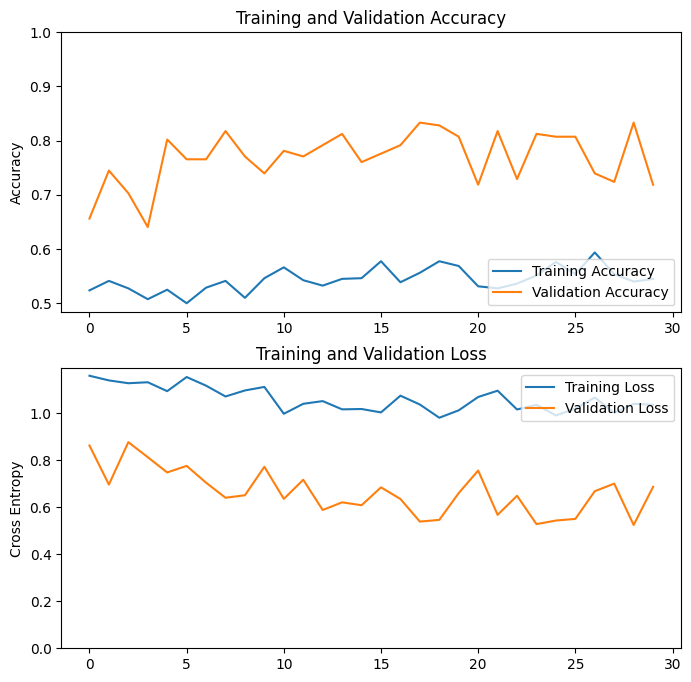

In [51]:
test_loss, test_acc = vggModel.evaluate(validation_generator)
print('test accuracy : ', test_acc)

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

13/13 [==============================] - 1s 104ms/step


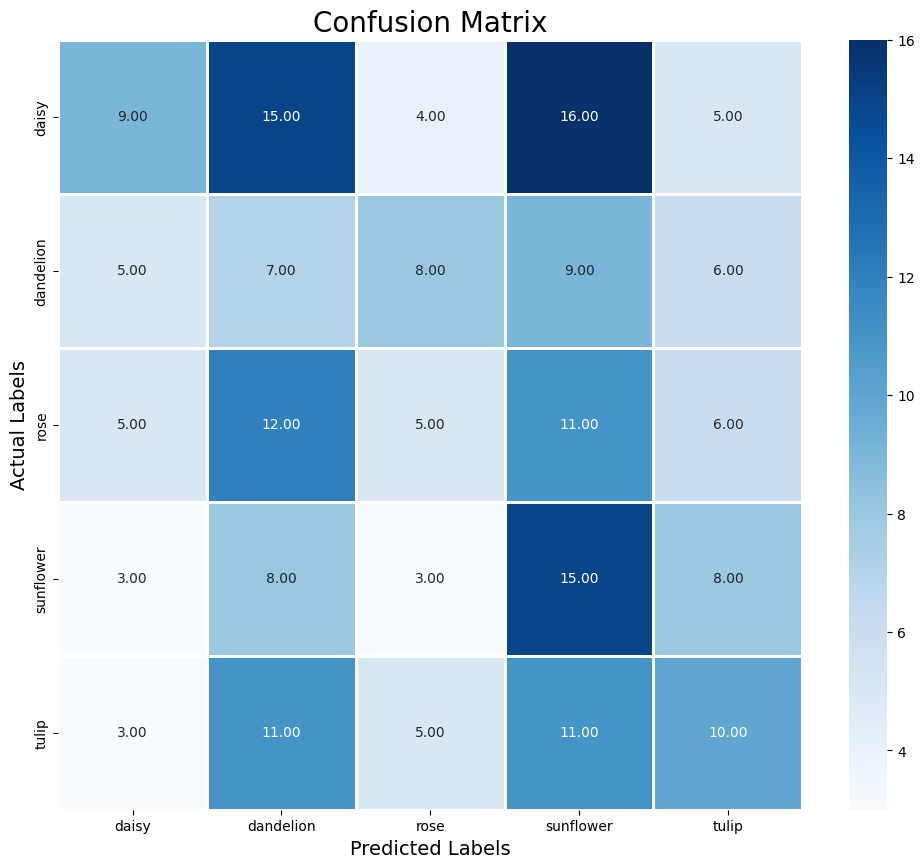

              precision    recall  f1-score   support

           0       0.36      0.18      0.24        49
           1       0.13      0.20      0.16        35
           2       0.20      0.13      0.16        39
           3       0.24      0.41      0.30        37
           4       0.29      0.25      0.27        40

    accuracy                           0.23       200
   macro avg       0.24      0.23      0.23       200
weighted avg       0.25      0.23      0.23       200



In [52]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=vggModel.predict(validation_generator)
valid_pred = [np.argmax(pred) for pred in valid_pres]
cm =confusion_matrix(validate_df['category'].astype('int'),valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(validate_df['category'].astype('int32'),valid_pred))

# InceptionV3

In [53]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model without the top layers
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the InceptionV3 layers
for layer in inception.layers:
    layer.trainable = False

# Build the custom model
incModel = Sequential([
    inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
])

# Compile the model
incModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
incModel.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 23906085 (91.19 MB)
Trainable params: 210

In [54]:
history2 = incModel.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,callbacks=[checkpoint,early_stopping])

Epoch 1/15


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x78749331f6d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x78749331f6d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - ETA: 0s - loss: 1.6558 - accuracy: 0.5788

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x787495cf5b40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x787495cf5b40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


50/50 [==============================] - 27s 376ms/step - loss: 1.6558 - accuracy: 0.5788 - val_loss: 0.7171 - val_accuracy: 0.7500
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.7337

50/50 [==============================] - 20s 395ms/step - loss: 0.8680 - accuracy: 0.7337 - val_loss: 0.4145 - val_accuracy: 0.8385
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7875

50/50 [==============================] - 20s 403ms/step - loss: 0.6044 - accuracy: 0.7875 - val_loss: 0.4187 - val_accuracy: 0.8542
Epoch 4/15
50/50 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.7750

50/50 [==============================] - 20s 403ms/step - loss: 0.5834 - accuracy: 0.7750 - val_loss: 0.3635 - val_accuracy: 0.8646
Epoch 5/15
50/50 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.8150

50/50 [==============================] - 17s 327ms/step - loss: 0.5077 - accuracy: 0.8150 - val_loss: 0.3649 - val_accuracy: 0.8490
Epoch 6/15
50/50 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.8100

50/50 [==============================] - 17s 334ms/step - loss: 0.5156 - accuracy: 0.8100 - val_loss: 0.3521 - val_accuracy: 0.8646
Epoch 7/15
50/50 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8388

50/50 [==============================] - 17s 337ms/step - loss: 0.4385 - accuracy: 0.8388 - val_loss: 0.3793 - val_accuracy: 0.8646
Epoch 8/15
50/50 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8288

50/50 [==============================] - 18s 364ms/step - loss: 0.4796 - accuracy: 0.8288 - val_loss: 0.3384 - val_accuracy: 0.8750
Epoch 9/15
50/50 [==============================] - ETA: 0s - loss: 0.4807 - accuracy: 0.8250

50/50 [==============================] - 17s 330ms/step - loss: 0.4807 - accuracy: 0.8250 - val_loss: 0.3460 - val_accuracy: 0.8594
Epoch 10/15
50/50 [==============================] - ETA: 0s - loss: 0.4379 - accuracy: 0.8388

50/50 [==============================] - 19s 378ms/step - loss: 0.4379 - accuracy: 0.8388 - val_loss: 0.3362 - val_accuracy: 0.8646
Epoch 11/15
50/50 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8500

50/50 [==============================] - 16s 329ms/step - loss: 0.3964 - accuracy: 0.8500 - val_loss: 0.4346 - val_accuracy: 0.8542
Epoch 12/15
50/50 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8825

50/50 [==============================] - 17s 336ms/step - loss: 0.3163 - accuracy: 0.8825 - val_loss: 0.3513 - val_accuracy: 0.8646
Epoch 13/15
50/50 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8612

50/50 [==============================] - 17s 341ms/step - loss: 0.3845 - accuracy: 0.8612 - val_loss: 0.3323 - val_accuracy: 0.8698
Epoch 14/15
50/50 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8587

50/50 [==============================] - 17s 334ms/step - loss: 0.3777 - accuracy: 0.8587 - val_loss: 0.3118 - val_accuracy: 0.8750
Epoch 15/15
50/50 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8813

50/50 [==============================] - 18s 367ms/step - loss: 0.3474 - accuracy: 0.8813 - val_loss: 0.2606 - val_accuracy: 0.8906


13/13 [==============================] - 3s 246ms/step - loss: 0.2723 - accuracy: 0.8850
test accuracy :  0.8849999904632568


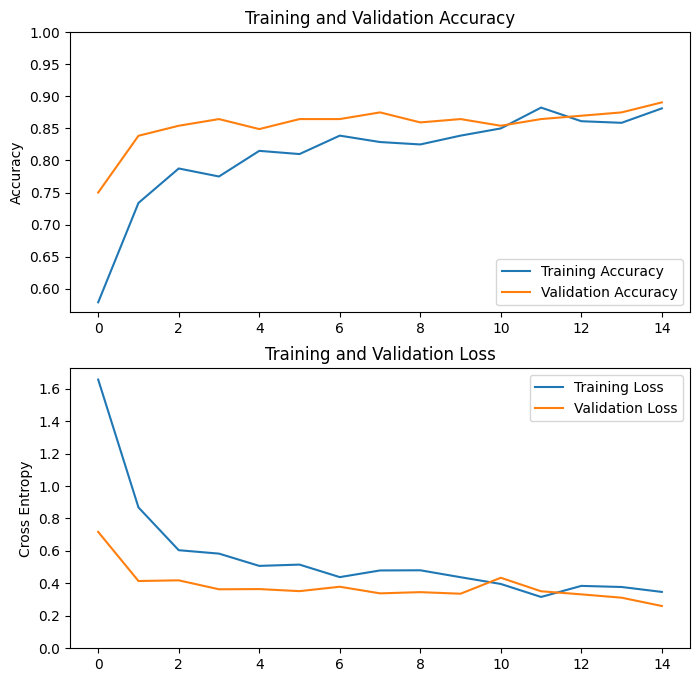

In [55]:
test_loss, test_acc = incModel.evaluate(validation_generator)
print('test accuracy : ', test_acc)

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x78749583caf0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x78749583caf0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 3s 99ms/step


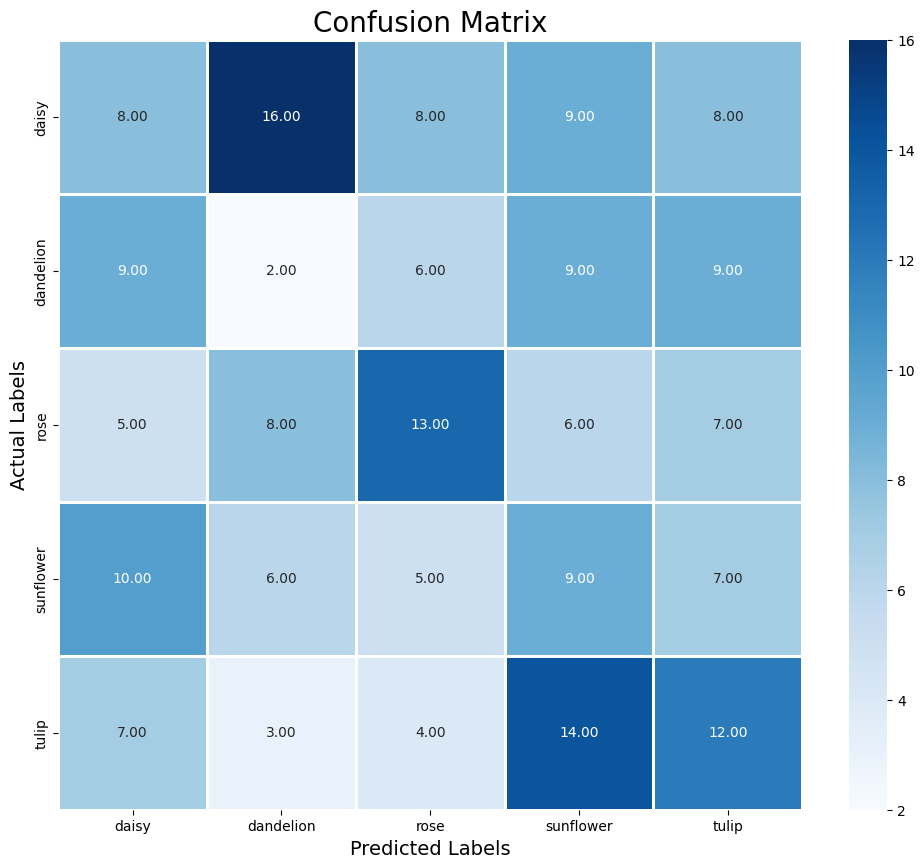

              precision    recall  f1-score   support

           0       0.21      0.16      0.18        49
           1       0.06      0.06      0.06        35
           2       0.36      0.33      0.35        39
           3       0.19      0.24      0.21        37
           4       0.28      0.30      0.29        40

    accuracy                           0.22       200
   macro avg       0.22      0.22      0.22       200
weighted avg       0.22      0.22      0.22       200



In [56]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=incModel.predict(validation_generator)
valid_pred = [np.argmax(pred) for pred in valid_pres]
cm =confusion_matrix(validate_df['category'].astype('int'),valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(validate_df['category'].astype('int32'),valid_pred))

In [79]:
import tensorflow as tf
incModel.save('inception_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [57]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    y = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Shortcut connection
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    # Merge
    y = layers.add([y, shortcut])
    y = layers.Activation(activation)(y)
    return y

# Build ResNet model
def build_resnet(input_shape, num_classes):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Stack residual blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust this according to your dataset
num_classes = 5  # Assuming multiclass classification

# Build the ResNet model
model_resnet = build_resnet(input_shape, num_classes)

# Compile the model
# model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
# Print model summary
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 112, 112, 64)         256       ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_94[0

In [59]:
history_resnet = model_resnet.fit(
    train_generator,  # Assuming you have defined train_generator for ResNet
    epochs=15,
    validation_data=validation_generator,  # Assuming you have defined validation_generator for ResNet
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/15


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7873dc7d7010>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7873dc7d7010>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.4075

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7873dc6e51b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7873dc6e51b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


50/50 [==============================] - 33s 342ms/step - loss: 1.8863 - accuracy: 0.4075 - val_loss: 41.4341 - val_accuracy: 0.2812
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 1.2368 - accuracy: 0.4812

50/50 [==============================] - 17s 340ms/step - loss: 1.2368 - accuracy: 0.4812 - val_loss: 2.1943 - val_accuracy: 0.2292
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.5325

50/50 [==============================] - 17s 347ms/step - loss: 1.1795 - accuracy: 0.5325 - val_loss: 2.3818 - val_accuracy: 0.2396
Epoch 4/15
50/50 [==============================] - ETA: 0s - loss: 1.1350 - accuracy: 0.5075

50/50 [==============================] - 18s 351ms/step - loss: 1.1350 - accuracy: 0.5075 - val_loss: 1.8647 - val_accuracy: 0.2760
Epoch 5/15
50/50 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.5500

50/50 [==============================] - 17s 337ms/step - loss: 1.1239 - accuracy: 0.5500 - val_loss: 1.1038 - val_accuracy: 0.5938
Epoch 6/15
50/50 [==============================] - ETA: 0s - loss: 1.1802 - accuracy: 0.5063

50/50 [==============================] - 17s 340ms/step - loss: 1.1802 - accuracy: 0.5063 - val_loss: 1.5106 - val_accuracy: 0.3229
Epoch 7/15
50/50 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.5625

50/50 [==============================] - 17s 337ms/step - loss: 1.1111 - accuracy: 0.5625 - val_loss: 2.7460 - val_accuracy: 0.4792
Epoch 8/15
50/50 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.5750

50/50 [==============================] - 17s 337ms/step - loss: 1.0356 - accuracy: 0.5750 - val_loss: 1.3292 - val_accuracy: 0.6250
Epoch 9/15
50/50 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.6012

50/50 [==============================] - 19s 379ms/step - loss: 0.9622 - accuracy: 0.6012 - val_loss: 1.6488 - val_accuracy: 0.5521
Epoch 10/15
50/50 [==============================] - ETA: 0s - loss: 0.9892 - accuracy: 0.5987

50/50 [==============================] - 18s 368ms/step - loss: 0.9892 - accuracy: 0.5987 - val_loss: 2.3662 - val_accuracy: 0.3958
Epoch 11/15
50/50 [==============================] - ETA: 0s - loss: 0.9807 - accuracy: 0.6037

50/50 [==============================] - 17s 334ms/step - loss: 0.9807 - accuracy: 0.6037 - val_loss: 2.5839 - val_accuracy: 0.4844
Epoch 12/15
50/50 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.6525

50/50 [==============================] - 19s 379ms/step - loss: 0.9423 - accuracy: 0.6525 - val_loss: 1.4696 - val_accuracy: 0.5104
Epoch 13/15
50/50 [==============================] - ETA: 0s - loss: 0.9628 - accuracy: 0.6237

50/50 [==============================] - 17s 338ms/step - loss: 0.9628 - accuracy: 0.6237 - val_loss: 1.3025 - val_accuracy: 0.5938
Epoch 14/15
50/50 [==============================] - ETA: 0s - loss: 0.9066 - accuracy: 0.6187

50/50 [==============================] - 17s 338ms/step - loss: 0.9066 - accuracy: 0.6187 - val_loss: 1.3706 - val_accuracy: 0.5885
Epoch 15/15
50/50 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.6488

50/50 [==============================] - 18s 361ms/step - loss: 0.8680 - accuracy: 0.6488 - val_loss: 1.0031 - val_accuracy: 0.6562


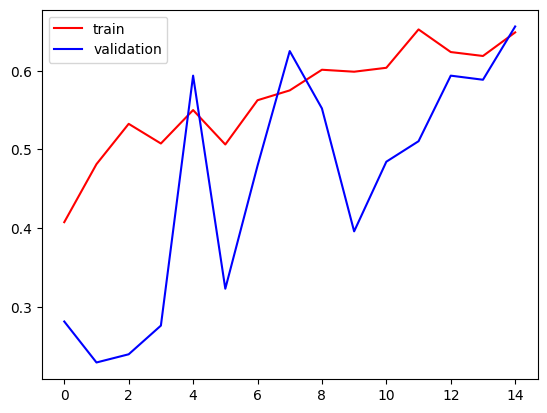

In [60]:
import matplotlib.pyplot as plt

plt.plot(history_resnet.history['accuracy'],color='red',label='train')
plt.plot(history_resnet.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

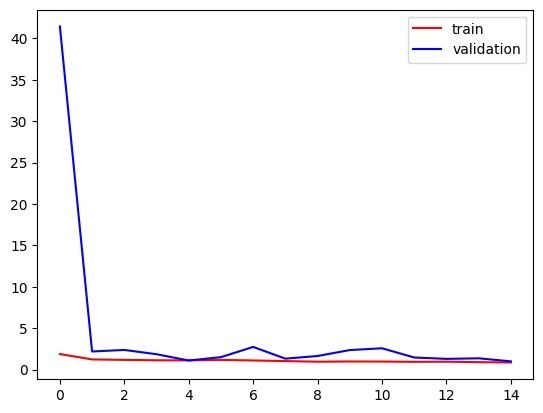

In [61]:
import matplotlib.pyplot as plt

plt.plot(history_resnet.history['loss'],color='red',label='train')
plt.plot(history_resnet.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [62]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Build MobileNetV2 model
def build_mobilenet(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # Freeze the convolutional base
    base_model.trainable = False

    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust this according to your dataset
num_classes = 5

# Build the MobileNetV2 model
model_mobilenet = build_mobilenet(input_shape, num_classes)

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [63]:
model_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [64]:


history_mobilenet = model_mobilenet.fit(
    train_generator,  # Assuming you have defined train_generator for ResNet
    epochs=15,
    validation_data=validation_generator,  # Assuming you have defined validation_generator for ResNet
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/15


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7874944d6b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7874944d6b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.6625

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x78749516a3b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x78749516a3b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


50/50 [==============================] - 22s 339ms/step - loss: 1.0092 - accuracy: 0.6625 - val_loss: 0.4357 - val_accuracy: 0.8594
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.8025

50/50 [==============================] - 16s 328ms/step - loss: 0.5494 - accuracy: 0.8025 - val_loss: 0.4541 - val_accuracy: 0.8542
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8525

50/50 [==============================] - 17s 329ms/step - loss: 0.4206 - accuracy: 0.8525 - val_loss: 0.3963 - val_accuracy: 0.8750
Epoch 4/15
50/50 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8625

50/50 [==============================] - 17s 335ms/step - loss: 0.3875 - accuracy: 0.8625 - val_loss: 0.3479 - val_accuracy: 0.9010
Epoch 5/15
50/50 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8888

50/50 [==============================] - 16s 317ms/step - loss: 0.3092 - accuracy: 0.8888 - val_loss: 0.3261 - val_accuracy: 0.8906
Epoch 6/15
50/50 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8750

50/50 [==============================] - 17s 328ms/step - loss: 0.3251 - accuracy: 0.8750 - val_loss: 0.2947 - val_accuracy: 0.8958
Epoch 7/15
50/50 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8838

50/50 [==============================] - 16s 315ms/step - loss: 0.3014 - accuracy: 0.8838 - val_loss: 0.3615 - val_accuracy: 0.8802
Epoch 8/15
50/50 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9125

50/50 [==============================] - 16s 330ms/step - loss: 0.2620 - accuracy: 0.9125 - val_loss: 0.2811 - val_accuracy: 0.9115
Epoch 9/15
50/50 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9237

50/50 [==============================] - 19s 392ms/step - loss: 0.2314 - accuracy: 0.9237 - val_loss: 0.3100 - val_accuracy: 0.9167
Epoch 10/15
50/50 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9162

50/50 [==============================] - 16s 316ms/step - loss: 0.2179 - accuracy: 0.9162 - val_loss: 0.2996 - val_accuracy: 0.9010
Epoch 11/15
50/50 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9388

50/50 [==============================] - 16s 317ms/step - loss: 0.1805 - accuracy: 0.9388 - val_loss: 0.3375 - val_accuracy: 0.8906
Epoch 12/15
50/50 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9500

50/50 [==============================] - 16s 321ms/step - loss: 0.1418 - accuracy: 0.9500 - val_loss: 0.2875 - val_accuracy: 0.9010
Epoch 13/15
50/50 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9375

50/50 [==============================] - 16s 319ms/step - loss: 0.1786 - accuracy: 0.9375 - val_loss: 0.3017 - val_accuracy: 0.9062
Epoch 14/15
50/50 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9463

50/50 [==============================] - 16s 321ms/step - loss: 0.1740 - accuracy: 0.9463 - val_loss: 0.3276 - val_accuracy: 0.8854
Epoch 15/15
50/50 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9513

50/50 [==============================] - 16s 318ms/step - loss: 0.1435 - accuracy: 0.9513 - val_loss: 0.3661 - val_accuracy: 0.8958


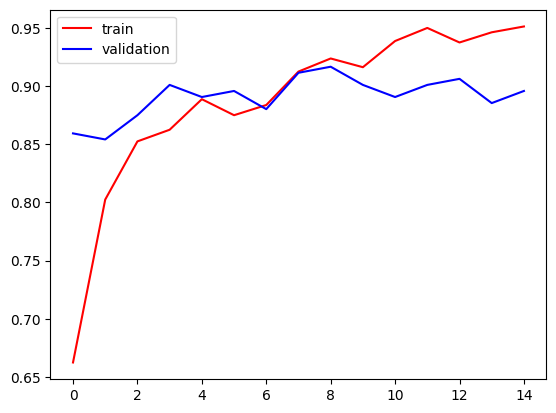

In [65]:
import matplotlib.pyplot as plt

plt.plot(history_mobilenet.history['accuracy'],color='red',label='train')
plt.plot(history_mobilenet.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [66]:
import cv2

In [67]:
test_img = cv2.imread(r'/content/drive/MyDrive/flower_dataset/flowers/rose/1402130395_0b89d76029.jpg')

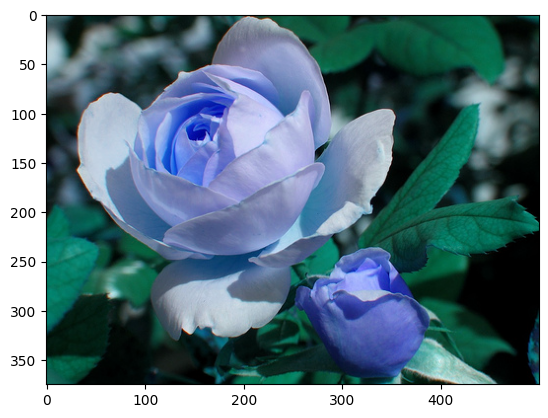

In [68]:
from matplotlib import pyplot as plt
plt.imshow(test_img)


In [69]:
test_img.shape

(375, 500, 3)

In [70]:
test_img = cv2.resize(test_img,(256,256))

In [71]:
test_input = test_img.reshape((1,256,256,3))

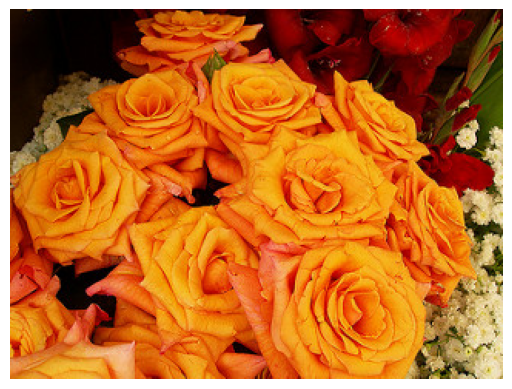

<ipython-input-84-6fe923fce0e8>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x787495b935b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x787495b935b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step
This image most likely belongs to rose with a 25.88 percent confidence.


In [84]:
import numpy as np
from PIL import Image, ImageOps
import cv2
import tensorflow as tf

def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    image = np.asarray(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    return prediction

# Assuming 'file' contains the path to the image file
# You may need to adapt this part based on how you're handling file uploads
file_path = "/content/drive/MyDrive/flower_dataset/flowers/rose/123128873_546b8b7355_n.jpg"  # Change this to your image path

# Load the model
model = tf.keras.models.load_model("inception_model.h5")  # Change this to your model path

# Read the image
image = Image.open(file_path)

# For Colab, you can display the image directly using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()

# For normal image input, you can use streamlit's st.image
# st.image(image, use_column_width=True)

# Make predictions
predictions = import_and_predict(image, model)
class_names = ["daisy", "dandelion", "rose","sunflower","tulip"]  # Define your class names here
score = tf.nn.softmax(predictions[0])

# Output the predictions
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 *np.max(score)))

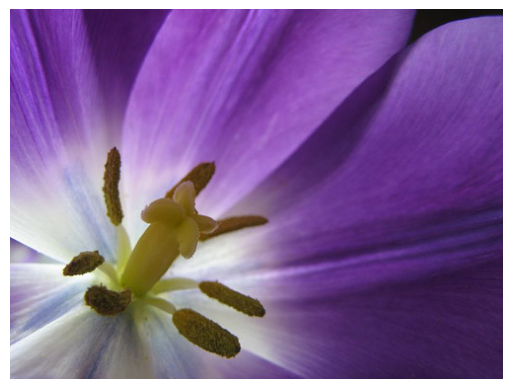

<ipython-input-87-a9675b083269>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7872981b9630>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7872981b9630>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1/1 [==============================] - 1s 1s/step
This image most likely belongs to tulip with a 40.46 percent confidence.


In [87]:
import numpy as np
from PIL import Image, ImageOps
import cv2
import tensorflow as tf

def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    image = np.asarray(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    return prediction

# Assuming 'file' contains the path to the image file
# You may need to adapt this part based on how you're handling file uploads
file_path = "/content/drive/MyDrive/flower_dataset/flowers/tulip/112334842_3ecf7585dd.jpg"  # Change this to your image path

# Load the model
model = tf.keras.models.load_model("inception_model.h5")  # Change this to your model path

# Read the image
image = Image.open(file_path)

# For Colab, you can display the image directly using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()

# For normal image input, you can use streamlit's st.image
# st.image(image, use_column_width=True)

# Make predictions
predictions = import_and_predict(image, model)
class_names = ["daisy", "dandelion", "rose","sunflower","tulip"]  # Define your class names here
score = tf.nn.softmax(predictions[0])

# Output the predictions
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 *np.max(score)))

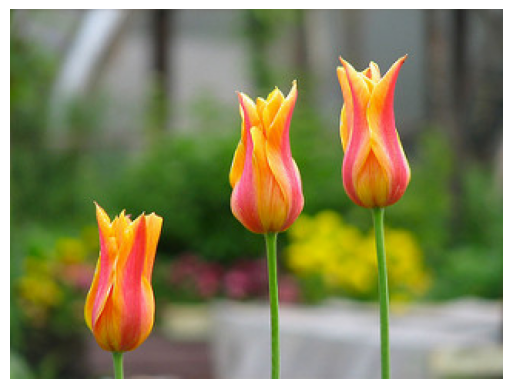

<ipython-input-91-ed3b819c9e30>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7874936177f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7874936177f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step
This image most likely belongs to tulip with a 40.46 percent confidence.


In [91]:
import numpy as np
from PIL import Image, ImageOps
import cv2
import tensorflow as tf

def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    image = np.asarray(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    return prediction

# Assuming 'file' contains the path to the image file
# You may need to adapt this part based on how you're handling file uploads
file_path = "/content/drive/MyDrive/flower_dataset/flowers/tulip/146884869_b1a8fa9c4e_n.jpg"  # Change this to your image path

# Load the model
model = tf.keras.models.load_model("inception_model.h5")  # Change this to your model path

# Read the image
image = Image.open(file_path)

# For Colab, you can display the image directly using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()

# For normal image input, you can use streamlit's st.image
# st.image(image, use_column_width=True)

# Make predictions
predictions = import_and_predict(image, model)
class_names = ["daisy", "dandelion", "rose","sunflower","tulip"]  # Define your class names here
score = tf.nn.softmax(predictions[0])

# Output the predictions
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 *np.max(score)))